<a href="https://colab.research.google.com/github/jmdn/GAN_music_generator/blob/master/MP3_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
!pip install torchaudio
import torchaudio

     |████████████████████████████████| 2.6MB 6.7MB/s 
     |████████████████████████████████| 748.9MB 19kB/s 
  Found existing installation: torch 1.1.0
    Uninstalling torch-1.1.0:
      Successfully uninstalled torch-1.1.0


In [0]:
#mp3 file of song used for training the discriminator
sound, sample_rate = torchaudio.load('/content/drive/My Drive/Colab Notebooks/Take_The_Veil_Cerpin_Taxt.mp3')


In [0]:
import numpy as np
import random
import torch

In [0]:
import torch.nn
import torch.nn.functional as nn
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable

Iter-0; D_loss: -12.482242584228516; G_loss: 16.59589958190918


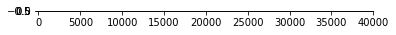

(1, 40000)
Iter-10; D_loss: -44.348106384277344; G_loss: 58.21223449707031


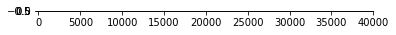

(1, 40000)


In [0]:
mb_size = 25
z_dim = 100

X_dim = 40000

conv1 = 10
kern1 = 4
stride1 = 10
h_dim = 100
h_dimG = 100
cnt = 0
lr = 1e-4

dtype = torch.FloatTensor


G = torch.nn.Sequential(
    torch.nn.ConvTranspose1d(in_channels=1, out_channels=1, kernel_size = kern1, stride = stride1),
    torch.nn.ReLU(),
    torch.nn.Linear(994, h_dimG),
    torch.nn.ReLU(),
    #torch.nn.BatchNorm1d(h_dim),
    torch.nn.Linear(h_dimG, X_dim),
    torch.nn.Sigmoid()
)


D = torch.nn.Sequential(
    #torch.nn.Conv1d(in_channels=1, out_channels=2, kernel_size = kern1, stride = stride1),
    torch.nn.ReLU(),
    torch.nn.Linear(X_dim, h_dim),
    torch.nn.ReLU(),
    #torch.nn.BatchNorm1d(h_dim),
    torch.nn.Linear(h_dim, 1),
)

#G.cuda()
#D.cuda()


def reset_grad():
    G.zero_grad()
    D.zero_grad()


G_solver = optim.RMSprop(G.parameters(), lr=lr)
D_solver = optim.RMSprop(D.parameters(), lr=lr)



for it in range(10000):
    
    #for data in train_data_gen:
    for itt in range(10):
        #inputs, labels = data
        # Sample data
        
        #data = next(iter(train_data_gen))
        z = Variable(torch.randn(mb_size, 1, z_dim))
        #z = Variable(z.cuda())
        
        clip_stack = []
        for x in range(25):
          start_c = random.randint(1,22007720)
          end_c = start_c + 20000
          clip = sound[:,start_c:end_c]
          clip = clip.reshape(1,40000)
          clip_stack.append(clip)
        X = torch.stack(clip_stack)
        

        
        X = np.reshape(X, (25, 1, 40000))
        
        

        # Dicriminator forward-loss-backward-update
        #print(np.shape(z))
        G_sample = G(z)
        #print(np.shape(G_sample))
        #G_sample = np.reshape(G_sample, (25, 1, 80000))
        D_real = D(X)
        D_fake = D(G_sample)

        D_loss = -(torch.mean(D_real) - torch.mean(D_fake))

        D_loss.backward()
        D_solver.step()

        # Weight clipping
        for p in D.parameters():
            p.data.clamp_(-0.01, 0.01)

        # Housekeeping - reset gradient
        reset_grad()

    # Generator forward-loss-backward-update
    X = torch.stack(clip_stack)
    #X = Variable(torch.from_numpy(X))
    
    clip_stack = []
    for x in range(25):
      #selects random clips from mp3 file
      start_c = random.randint(1,22007720)
      end_c = start_c + 20000
      clip = sound[:,start_c:end_c]
      clip = clip.reshape(1,40000)
      clip_stack.append(clip)
    X = torch.stack(clip_stack)
    
    X = np.reshape(X, (25, 1, 40000))
    #X = Variable(X.cuda())
    z = Variable(torch.randn(mb_size, 1, z_dim))
    #z = Variable(z.cuda())

    G_sample = G(z)
    
    
    D_fake = D(G_sample)

    G_loss = -torch.mean(D_fake)

    G_loss.backward()
    G_solver.step()

    # Housekeeping - reset gradient
    reset_grad()

    # Print and plot every now and then
    if it % 10 == 0:
        
        
        print('Iter-{}; D_loss: {}; G_loss: {}'
              .format(it, D_loss.data.cpu().numpy(), G_loss.data.cpu().numpy()))


        examp = G_sample.cpu().detach().numpy()[0]
        plt.imshow(examp.reshape(1, 40000))
        plt.show()
        print(np.shape(examp))
        examp = examp.reshape(2,20000)
        
        torch_ex_float_tensor = torch.from_numpy(examp)
        #print(examp.reshape(4, 50))
        #imageio.imwrite('/disk1/pore_data/jeff_saved/aptamer_gen/generative_model_test/test_gen_DNA_new_'+str(it)+'.png', examp.reshape(4, 50))
        torchaudio.save('/content/drive/My Drive/Colab Notebooks/Mp3_stuff/training_mp3s/generated_clip_ConvTrans_' + str(it) +  '.mp3', torch_ex_float_tensor, sample_rate)
